# Running in parallel

Running with multiple jobs is a good idea. this could be done at multiple levels (i.e., sending different jobs for different vertices). We can also get some speed gains by passing a pool to emcee

To run in parallel the system will pickle the objects. this introduces a speed cost - the larger the object to pickle the slower you will be. If you can set things to be available globally this should speed stuff up. Setting things globally could also be a problem later...

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')[:,:,5:]
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
# HRF is determined by coefficients for the canonical HRF, its time derivative, and its dispersion derivative
# Here we set it at 1, 4.6 and 0 (what we have found to work at spinoza)
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0]) 

# Load the runs
psc_runs = np.load('eg_data.npy')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
dm.shape

(100, 100, 220)

In [3]:
from pfa_scripts.load_saved_info import *
psc_runs = load_data_tc('sub-01', 'AS0')['AS0']


In [4]:
# plt.plot(psc_runs[100,:])

# Parallel - microprobing

In [41]:
# Some starting positions... (a bit random - but lets go for it for now)
pol = np.linspace(0, 2*np.pi, 14)
ecc = np.array([1, 2.5, 5]) # , 2,3, 4,])
pol,ecc = np.meshgrid(pol, ecc)
x,y = ecc*np.cos(pol), ecc*np.sin(pol)
x,y = x.flatten(), y.flatten()
walkers = np.array([x,y]).T
# -> need to specify the "move", i.e., how it makes steps
import emcee 
moves = emcee.moves.GaussianMove(cov=.01, mode='vector') # Setting cov=.1 for a small step size


In [6]:
# Apparently this can interfere if not set to 1
os.environ['OMP_NUM_THREADS'] = '1'

### test timing

In [7]:
from prfpy_bayes.micro_probe import MicroProbe #, PrfpyModelGlobal, prfpy_global_model
n_steps = 100

In [8]:

# n_steps = 100 # Small number of steps for starting...
# time_start = datetime.now()
# bprf_serial = MicroProbe(
#     prfpy_model = prfpy_model,  # prfpy model objects
#     real_ts = psc_runs,         # time series (data)
#     bounds = [-5,5],            # bounds for x,y
#     tiny_prf_size = 0.01,       # tiny prf size     
# )

# time_start = datetime.now()
# bprf_serial.run_mcmc_fit(
#     idx=0,                      # Index of the vertex times series to fit     
#     n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
#     walkers=walkers,            # Starting points
#     n_steps=n_steps,                # How many steps to takes
#     kwargs_sampler={'moves':moves},  # Arguments for the sampler
#     kwargs_run = {'skip_initial_state_check':True, },        
# )
# t1 = datetime.now()-time_start
# print(f'Time taken: {t1}')


In [47]:
# *************************************************************

n_steps = 500
time_start = datetime.now()
bprf_par = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)
# Same again but wiht multiprocessing
import multiprocessing
time_start = datetime.now()
# from prfpy_bayes.micro_probe import prfpy_global_model
# from prfpy_bayes.micro_probe import prfpy_global_model
from prfpy_bayes.micro_probe import prfpy_global_model
with multiprocessing.Pool(
    len(walkers), 
    # initializer=init_global_model
    ) as pool:
    # So it can be accessed globally!!
    # from prfpy_bayes.micro_probe import prfpy_global_model
    prfpy_global_model.set_model(prfpy_model)
    bprf_par.run_mcmc_fit(
        idx=100,                      # Index of the vertex times series to fit     
        n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
        walkers=walkers,            # Starting points
        n_steps=100,                # How many steps to takes
        kwargs_sampler={'moves':moves},  # Arguments for the sampler
        kwargs_run = {'skip_initial_state_check':True, }, #'tune':True, 'progress':'notebook'},        
        pool=pool,
    )

t2 = datetime.now()-time_start
print(f'{t2}')


Running in parallel
prf_params.shape[-1]=8
include hrf = True
include rsq = True
0:00:10.209247


In [28]:
a = load_data_prf('sub-01', 'AS0', 'gauss')

/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl


In [30]:
a['AS0']['gauss'][100,:]

array([ 0.97838044, -2.3758657 ,  1.30260044,  0.0166581 ,  0.        ,
        1.        ,  0.        ,  0.55402138])

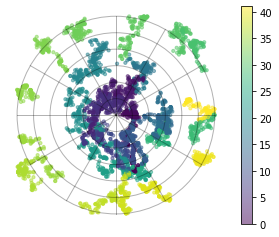

In [50]:
bprf_par.sampler[100].visual_field(
    th={},
    # th={'min-step_id':450},
    dot_size=10, 
    dot_col='walker_id',
)
# plt.gca().scatter(0.97, -2.37, s=200, color='r')

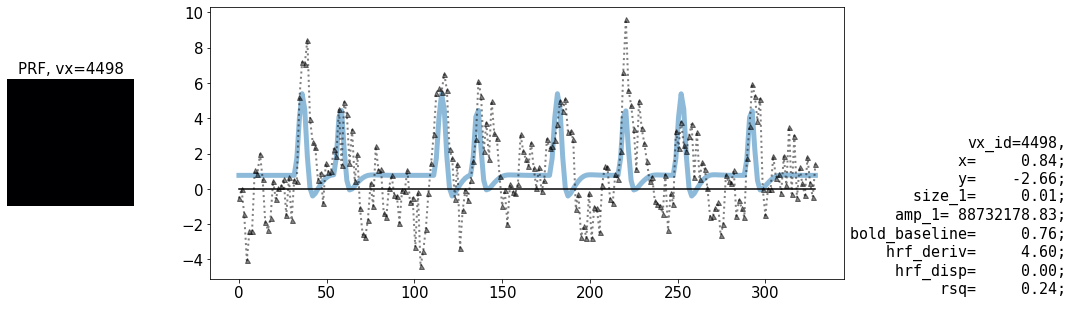

In [22]:
bprf_par.sampler[100].pd_params['rsq'].argmax()
_ = bprf_par.sampler[100].prf_ts_plot(4498)